# Part 6: Horse Race Prediction
## Backtesting Strategy Using our ML Models

Betting strategy: To place $1 bet for each prediction in each race. If prediction is correct, we will collect $1 x odds. Otherwise, we lose $1

The final result is positive if we win some money and negative if we lose.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# rcParams background color
plt.rcParams['figure.facecolor'] = 'white'

%matplotlib inline

In [2]:
# Read in the train file
df_train = pd.read_csv('data/df_train.csv')
df_train.reset_index(inplace=True, drop=True)
df_train.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,1.0,DOUBLE DRAGON,K019,B Prebble,D Cruz,133,1032,1,-,...,NaN,2014-001,1,1.0,1400,1,1,1,6.052910,7.381862
1,2,2.0,PLAIN BLUE BANNER,S070,D Whyte,D E Ferraris,133,1075,13,2,...,NaN,2014-001,2,2.0,1400,0,1,1,5.825153,6.611465
2,3,10.0,GOLDWEAVER,P072,Y T Cheng,Y S Tsui,121,1065,3,2,...,NaN,2014-001,3,3.0,1400,0,1,1,7.857759,6.888713
3,4,3.0,SUPREME PROFIT,P230,J Moreira,C S Shum,132,1222,2,2,...,NaN,2014-001,4,4.0,1400,0,0,1,4.179172,6.680328
4,5,7.0,THE ONLY KID,H173,Z Purton,K W Lui,125,1136,9,4-1/4,...,NaN,2014-001,5,5.0,1400,0,0,1,5.284127,6.903955


In [3]:
# Read in the test file
df_test = pd.read_csv('./data/df_test.csv')
df_test.reset_index(inplace=True, drop=True)
df_test.head()

,finishing_position,horse_number,horse_name,horse_id,jockey,trainer,actual_weight,declared_horse_weight,draw,length_behind_winner,...,running_position_6,race_id,recent_6_runs,recent_ave_rank,race_distance,HorseWin,HorseRankTop3,HorseRankTop50Percent,jockey_ave_rank,trainer_ave_rank
0,1,5.0,POWERMAX,A009,N Callan,R Gibson,126,1124,9,-,...,NaN,2016-328,1/4/3/3,2.750000,1200,1,1,1,6.438751,6.715420
1,2,2.0,BUDDY BUNDY,T157,K K Chiong,D Cruz,127,1193,8,SH,...,NaN,2016-328,2/11/5/2/6/9,6.812500,1200,0,1,1,6.499033,7.381862
2,3,3.0,ROYALE ELEGANCE,S098,O Murphy,W Y So,131,1090,1,1/2,...,NaN,2016-328,3/2/4/4/5/7,4.480000,1200,0,1,1,8.103093,7.048587
3,4,11.0,CONFUCIUS SPIRIT,S329,K Teetan,D E Ferraris,120,1073,2,1-1/4,...,NaN,2016-328,4/3/5/8/2/4,6.484848,1200,0,0,1,6.691367,6.611465
4,5,10.0,STARLIGHT,V273,Z Purton,C H Yip,122,1056,12,1-1/4,...,NaN,2016-328,5/6/14/12,9.250000,1200,0,0,1,5.284127,7.177492


In [4]:
df_test.columns

Index(['finishing_position', 'horse_number', 'horse_name', 'horse_id',
       'jockey', 'trainer', 'actual_weight', 'declared_horse_weight', 'draw',
       'length_behind_winner', 'running_position_1', 'running_position_2',
       'running_position_3', 'running_position_4', 'finish_time', 'win_odds',
       'running_position_5', 'running_position_6', 'race_id', 'recent_6_runs',
       'recent_ave_rank', 'race_distance', 'HorseWin', 'HorseRankTop3',
       'HorseRankTop50Percent', 'jockey_ave_rank', 'trainer_ave_rank'],
      dtype='object')

In [5]:
# Read in our 4 classification predictions
lr_pred = pd.read_csv('./predictions/lr_pred.csv')
gnb_pred = pd.read_csv('./predictions/gnb_pred.csv')
rfc_pred = pd.read_csv('./predictions/rfc_pred.csv')
smote_rfc_pred = pd.read_csv('./predictions/smote_rfc_pred.csv')

In [6]:
# Read in our 4 regression predictions
ridge_pred = pd.read_csv('./predictions/ridge_pred.csv')
knn_pred = pd.read_csv('./predictions/knn_pred.csv')
rf_pred = pd.read_csv('./predictions/rf_pred.csv')
lgbm_pred = pd.read_csv('./predictions/lgbm_pred.csv')

### Baseline Case: Bet on horse with the lowest odds

In [7]:
df_test['win_odds'].sort_values(ascending=True).index[0]

4951

In [8]:
# Check on baseline case where we just bet on the horse with the lowest odds
# Test on the df_train and df_test dataframes

def buy_lowest_odds(df, best_odds, graph=True):

    money=0
    bets_made=[]
    cumulative_money=[]

    for race_id in df['race_id'].unique():
        # Make a temporary dataframe
        df_temp = df[df['race_id'] == race_id]

        # Find the index with the lowest odds
        idx = df_temp['win_odds'].sort_values(ascending=True)[:best_odds].index

        bet_counter=0

        for i in idx:
            # If the horse wins, add the win_odds to the money
            if df_temp['finishing_position'][i] == 1:
                money += (df_temp['win_odds'][i] - 1)
                bet_counter += 1
                cumulative_money.append(money)
            else:
                money += -1
                bet_counter += 1
                cumulative_money.append(money)

        bets_made.append(bet_counter)    

    if graph==True: 
        # Plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # Plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Total Bets Made')
        plt.show()
        
    # Print the final money and bets made
    print('Final Money made from Baseline: ', round(money,3))
    print('Total Bets Made: ', round(sum(bets_made),3))

In [9]:
buy_lowest_odds(df_train, 1, False)

Final Money made from Baseline:  -167.5
Total Bets Made:  1887


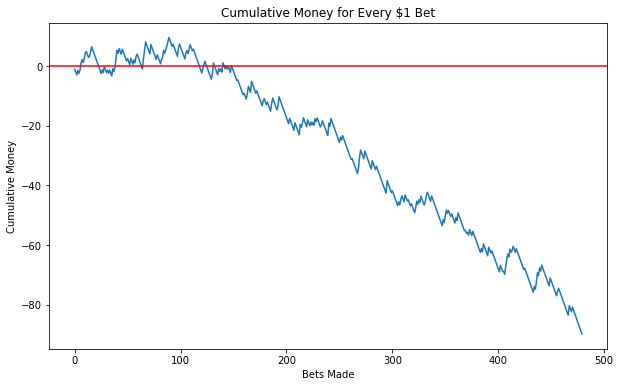

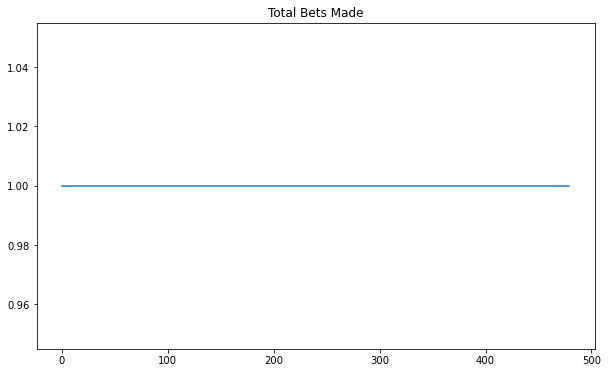

Final Money made from Baseline:  -89.8
Total Bets Made:  480


In [10]:
buy_lowest_odds(df_test, 1, True)

In [11]:
buy_lowest_odds(df_train, 3, False)

Final Money made from Baseline:  -760.8
Total Bets Made:  5661


In [12]:
buy_lowest_odds(df_test, 3, False)

Final Money made from Baseline:  -153.0
Total Bets Made:  1440


### Strategy 1: Buy Top Prediction
- If top horse prediction is 1, we make a bet, else we don't.

In [13]:
# Define a function to backtest the betting strategy
def simple_class_strategy(model_pred, graph=True):

    df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseWin']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

### Strategy 2: Buy Fastest Timing
- We bet on the horse with the fastest predicted timing.

In [14]:
# define regression backtest function
def simple_reg_strategy(model_pred, graph=True):
        
        df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 'HorseWin', 'horse_id']]

        # rename columns
        df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                        'horse_id': 'HorseID', 
                                                        'HorseWin':'ActualWin'})
        
        # merge the prediction with the test data
        df_test_results['pred_time'] = model_pred['0']

        money = 0
        bets_made = []
        cumulative_money = [0]

        for race_id in df_test_results['RaceID'].unique():

                # make a temporary dataframe one for that particular race
                temp_df = df_test_results[df_test_results['RaceID']==race_id]

                # bet only on the horse with the fastest time
                # return dataframe where the time is the minimum
                bets = temp_df[temp_df['pred_time']==temp_df['pred_time'].min()]

                # deduct money for bets we made
                deduction  = -len(bets)

                # amount won from bets
                # sum of multiplying the odds with the prediction
                amount_won = sum(bets['win_odds']*bets['ActualWin'])
                
                # add the amount won to the money
                money += (amount_won + deduction)

                # append the money to the cumulative money list
                cumulative_money.append(money)

                # append the bets made to the bets made list
                bets_made.append(len(bets))
        
        if graph==True:
                # plot the cumulative money
                plt.figure(figsize=(10, 6))
                plt.plot(cumulative_money)
                plt.axhline(y=0, color='r', linestyle='-')
                plt.title('Cumulative Money for Every $1 Bet')
                plt.xlabel('Bets Made')
                plt.ylabel('Cumulative Money')
                plt.show()

                # plot the bets made
                plt.figure(figsize=(10, 6))
                plt.plot(bets_made)
                plt.title('Bets Made')
                plt.show()

        # print the final money and bets made
        print('Final Money: ', round(money, 3))
        print('Total Bets Made: ', round(sum(bets_made),3), '\n')

        return money, bets_made
                

### Strategy 3: Buy Top 3 Predictions
- We bet on the top 3 horses with the highest probability of winning

In [15]:
# Define a function to backtest the betting strategy
def top3_strategy(model_pred, graph=True):

    df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_backtest = pd.merge(model_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_backtest['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_backtest[df_backtest['RaceID']==race_id]

        # find out the bets we made
        bets = temp_df[temp_df['HorseRankTop3']==1]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

### Strategy 4: Buy Only Fast and Good
- We bet on the horse that is predicted to be in the top 1, top 3 and has the best timing.

In [16]:
# Define a function to backtest the betting strategy
def hybrid_strategy(class_pred, reg_pred, graph=True):

    df_test_results = df_test[['finishing_position', 'win_odds', 'race_id', 
                               'HorseWin', 'horse_id']]

    # rename columns
    df_test_results = df_test_results.rename(columns={'race_id': 'RaceID', 
                                                    'horse_id': 'HorseID', 
                                                    'HorseWin':'ActualWin'})
    
    # merge the prediction with the test data
    df_hybrid = pd.merge(class_pred, df_test_results, on=('RaceID', 'HorseID'), how='left')
    df_hybrid['pred_time'] = reg_pred['0']

    money = 0
    bets_made = []
    cumulative_money = [0]

    for race_id in df_hybrid['RaceID'].unique():

        # make a temporary dataframe one for that particular race
        temp_df = df_hybrid[df_hybrid['RaceID']==race_id]

        # find out the bets we made
        top_filter = temp_df['HorseWin']==1
        top3_filter = temp_df['HorseRankTop3']==1
        time_filter = temp_df['pred_time']==temp_df['pred_time'].min()

        bets = temp_df[(top_filter) & (top3_filter) & (time_filter)]

        # deduct money for bets we made
        deduction  = -len(bets)

        # amount won from bets
        # sum of multiplying the odds with the prediction
        amount_won = sum(bets['win_odds']*bets['ActualWin'])
        
        # add the amount won to the money
        money += (amount_won + deduction)

        # append the money to the cumulative money list
        cumulative_money.append(money)

        # append the bets made to the bets made list
        bets_made.append(len(bets))
    
    if graph==True:
        # plot the cumulative money
        plt.figure(figsize=(10, 6))
        plt.plot(cumulative_money)
        plt.axhline(y=0, color='r', linestyle='-')
        plt.title('Cumulative Money for Every $1 Bet')
        plt.xlabel('Bets Made')
        plt.ylabel('Cumulative Money')
        plt.show()

        # plot the bets made
        plt.figure(figsize=(10, 6))
        plt.plot(bets_made)
        plt.title('Bets Made')
        plt.show()

    # print the final money and bets made
    print('Final Money: ', round(money, 3))
    print('Total Bets Made: ', round(sum(bets_made),3), '\n')

    return money, bets_made

### Run Strategy 1

In [17]:
class_pred_dict = {'Logistic Regression': lr_pred, 
                    'Gaussian Naive Bayes': gnb_pred,
                    'Random Forest Classifier': rfc_pred,
                    'SMOTE + RF': smote_rfc_pred}

reg_pred_dict = {'Ridge Regression': ridge_pred,
                'KNN Regression': knn_pred,
                'Random Forest Regressor': rf_pred,
                'LGBM': lgbm_pred}

In [18]:
# Create a dataframe to store the results
strat1_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, class_model in class_pred_dict.items():

        # Print the model name
        print(model_name)

        # change False to True if you want to view the graph
        money, bets = simple_class_strategy(class_model, graph=False)

        # Append the results to the dataframe
        strat1_results.loc[len(strat1_results)] = [model_name, money, sum(bets)]

Logistic Regression
Final Money:  23.0
Total Bets Made:  32 

Gaussian Naive Bayes
Final Money:  10.7
Total Bets Made:  177 

Random Forest Classifier
Final Money:  268.1
Total Bets Made:  68 

SMOTE + RF
Final Money:  375.2
Total Bets Made:  743 



Ridge Regression


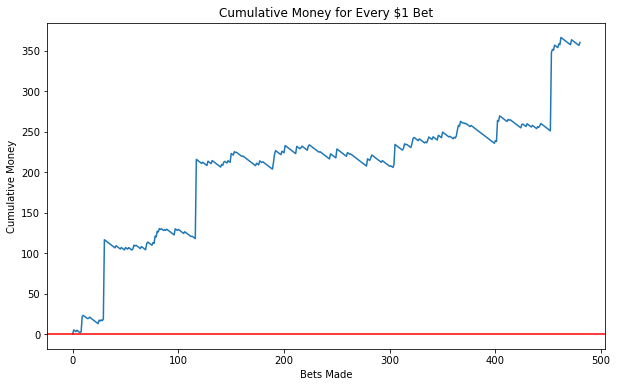

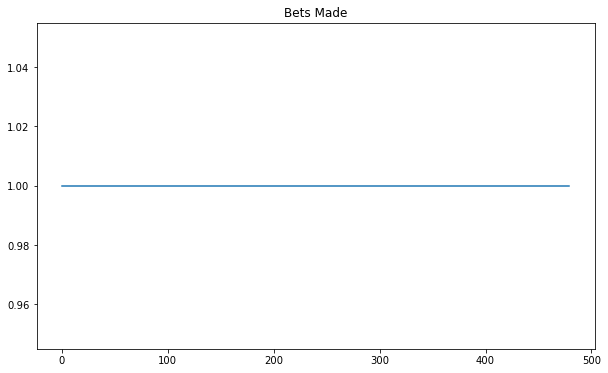

Final Money:  360.4
Total Bets Made:  480 

KNN Regression


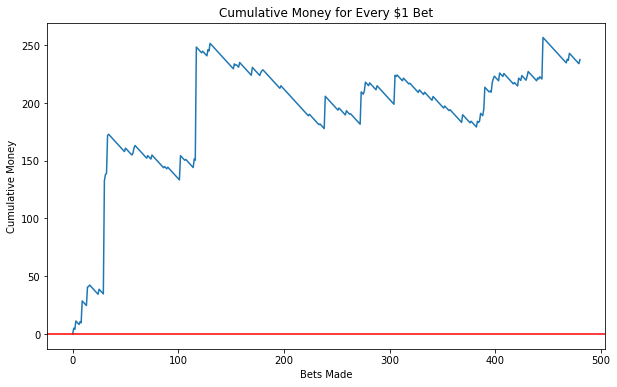

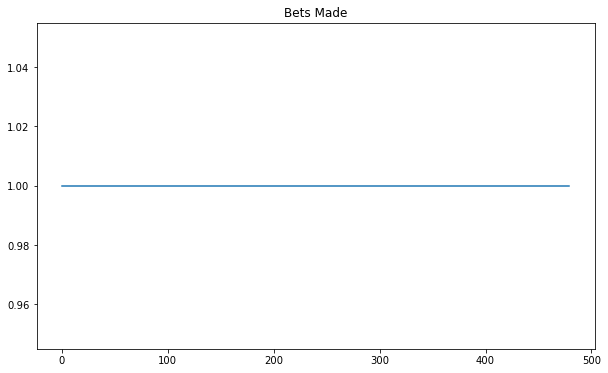

Final Money:  237.6
Total Bets Made:  480 

Random Forest Regressor


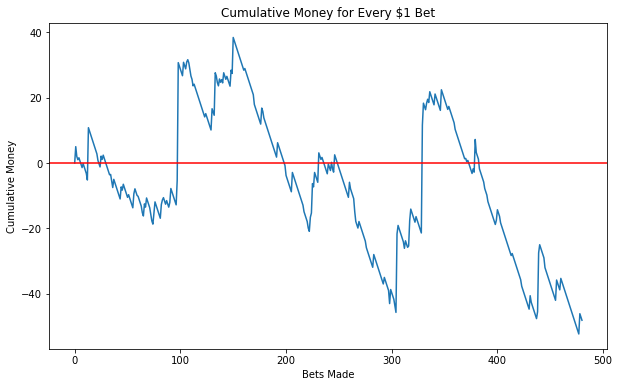

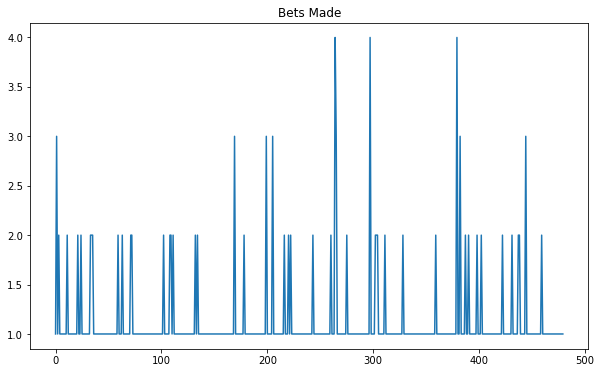

Final Money:  -48.1
Total Bets Made:  542 

LGBM


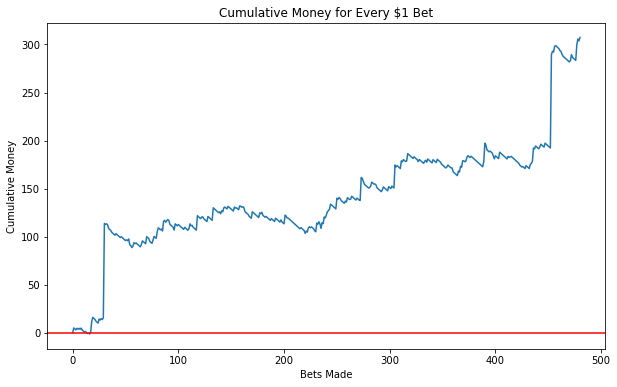

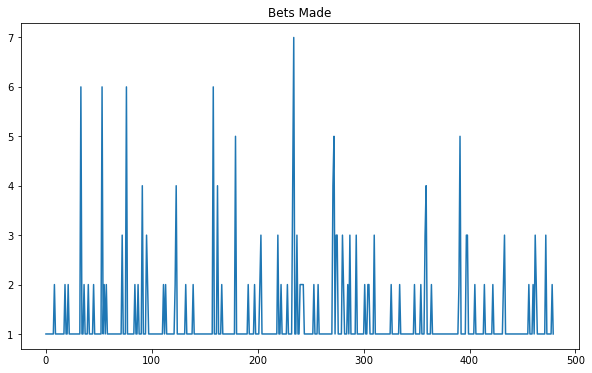

Final Money:  307.3
Total Bets Made:  617 



In [19]:
# Create a dataframe to store the results
strat2_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, reg_model in reg_pred_dict.items():

        # Print the model name
        print(model_name)

        # change False to True if you want to view the graph
        money, bets = simple_reg_strategy(reg_model, graph = True)

        # Append the results to the dataframe
        strat2_results.loc[len(strat2_results)] = [model_name, money, sum(bets)]

In [20]:
# Create a dataframe to store the results
strat3_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name, class_model in class_pred_dict.items():

        # change False to True if you want to view the graph
        money, bets = top3_strategy(class_model, graph = False)

        # Append the results to the dataframe
        strat3_results.loc[len(strat3_results)] = [model_name, money, sum(bets)]

Final Money:  172.8
Total Bets Made:  550 

Final Money:  137.4
Total Bets Made:  939 

Final Money:  237.1
Total Bets Made:  599 

Final Money:  225.2
Total Bets Made:  1728 



In [21]:
# Create a dataframe to store the results
strat4_results = pd.DataFrame(columns=['Model', 'Money', 'Bets Made'])

for model_name1, model1 in class_pred_dict.items():
    for model_name2, model2 in reg_pred_dict.items():
        combo_model = model_name1, model_name2

        # Print the combo model name
        print(combo_model)

        # change False to True if you want to view the graph
        money, bets = hybrid_strategy(model1, model2, graph = False)

        # Append the results to the dataframe
        strat4_results.loc[len(strat4_results)] = [combo_model, money, sum(bets)]

('Logistic Regression', 'Ridge Regression')
Final Money:  16.9
Total Bets Made:  20 

('Logistic Regression', 'KNN Regression')
Final Money:  8.6
Total Bets Made:  11 

('Logistic Regression', 'Random Forest Regressor')
Final Money:  1.7
Total Bets Made:  9 

('Logistic Regression', 'LGBM')
Final Money:  19.4
Total Bets Made:  28 

('Gaussian Naive Bayes', 'Ridge Regression')
Final Money:  16.5
Total Bets Made:  72 

('Gaussian Naive Bayes', 'KNN Regression')
Final Money:  8.4
Total Bets Made:  62 

('Gaussian Naive Bayes', 'Random Forest Regressor')
Final Money:  -2.4
Total Bets Made:  60 

('Gaussian Naive Bayes', 'LGBM')
Final Money:  3.1
Total Bets Made:  116 

('Random Forest Classifier', 'Ridge Regression')
Final Money:  232.1
Total Bets Made:  32 

('Random Forest Classifier', 'KNN Regression')
Final Money:  116.9
Total Bets Made:  19 

('Random Forest Classifier', 'Random Forest Regressor')
Final Money:  7.6
Total Bets Made:  18 

('Random Forest Classifier', 'LGBM')
Final Mone

### View the results

In [22]:
# Print Strategy 1 Results
strat1_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
3,SMOTE + RF,375.2,743
2,Random Forest Classifier,268.1,68
0,Logistic Regression,23.0,32
1,Gaussian Naive Bayes,10.7,177


In [23]:
# Print strategy 2 results
strat2_results.sort_values(by='Money', ascending=False)


,Model,Money,Bets Made
0,Ridge Regression,360.4,480
3,LGBM,307.3,617
1,KNN Regression,237.6,480
2,Random Forest Regressor,-48.1,542


In [24]:
# Print strategy 3 results
strat3_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
2,Random Forest Classifier,237.1,599
3,SMOTE + RF,225.2,1728
0,Logistic Regression,172.8,550
1,Gaussian Naive Bayes,137.4,939


In [25]:
# Print strategy 4 results
strat4_results.sort_values(by='Money', ascending=False)

,Model,Money,Bets Made
15,"(SMOTE + RF, LGBM)",307.6,231
12,"(SMOTE + RF, Ridge Regression)",302.3,155
11,"(Random Forest Classifier, LGBM)",261.1,54
8,"(Random Forest Classifier, Ridge Regression)",232.1,32
13,"(SMOTE + RF, KNN Regression)",171.6,91
9,"(Random Forest Classifier, KNN Regression)",116.9,19
14,"(SMOTE + RF, Random Forest Regressor)",20.6,140
3,"(Logistic Regression, LGBM)",19.4,28
0,"(Logistic Regression, Ridge Regression)",16.9,20
4,"(Gaussian Naive Bayes, Ridge Regression)",16.5,72


Happy to say that all the top models for the 4 different strategies seem to perform well during the testing. This was quite surprising given that the base case of choosing the horse with the best odds gave quite a negative result.